# Limpieza y Preparación de Datos
## Sistema Integral Multi-Capa para la Detección de Desinformación

**Objetivo**: Transformar los datos crudos en conjuntos de datos limpios, validados y listos para el modelado.

### Plan de Ejecución:
1. **Análisis de Nulos y Ceros** (Validación Semántica)
2. **Análisis de Desbalance de Clases** (Paso Crítico)
3. **Limpieza y Selección de Columnas** (Evitar Data Leakage)
4. **Imputación de Valores Faltantes** (Estrategia Robusta)
5. **Escalado de Características Numéricas** (Estandarización)
6. **Guardado de Datos Procesados** (Pipeline Reproducible)

In [1]:
# Importaciones esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler  # Cambio: Más robusto contra outliers
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from scipy.stats import zscore  # Para detección de outliers
import warnings
import os
import joblib
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("- Librerías cargadas correctamente")
print("- Directorio de trabajo:", os.getcwd())

- Librerías cargadas correctamente
- Directorio de trabajo: y:\Diplomado\ProyectoFinal\notebooks


## 1. Carga de Datos

In [2]:
# Carga del dataset principal (Features Tradicionales)
print("- Cargando dataset principal...")
df1 = pd.read_csv('../dataset1/Features_For_Traditional_ML_Techniques.csv')

print(f"- Dataset cargado exitosamente")
print(f"- Dimensiones originales: {df1.shape[0]:,} filas x {df1.shape[1]} columnas")
print(f"- Uso de memoria: {df1.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Vista rápida del dataset
print("\nPrimeras 3 filas:")
display(df1.head(3))

- Cargando dataset principal...
- Dataset cargado exitosamente
- Dimensiones originales: 134,198 filas x 64 columnas
- Uso de memoria: 124.33 MB

Primeras 3 filas:


,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10


## 2. Análisis de Nulos y Ceros (Validación Semántica)

> No se puede confiar ciegamente en los datos. Un valor de **0** o `NaN` puede significar cosas distintas. Debemos entenderlo antes de actuar.

In [3]:
print("ANÁLISIS DE NULOS Y CEROS")
print("="*50)

# 1.1 Información general del dataset
print("\nInformación general del dataset:")
print(df1.info())

# 1.2 Análisis de valores nulos
print("\nAnálisis de valores nulos:")
null_counts = df1.isnull().sum()
null_percentages = (null_counts / len(df1)) * 100

null_summary = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores_Nulos': null_counts.values,
    'Porcentaje': null_percentages.values
})

null_summary = null_summary[null_summary['Valores_Nulos'] > 0].sort_values('Porcentaje', ascending=False)

if len(null_summary) > 0:
    print(f"-  Columnas con valores nulos: {len(null_summary)}")
    display(null_summary)
else:
    print("- No hay valores nulos en el dataset")

# 1.3 Análisis de ceros (validación semántica)
print("\nAnálisis de ceros en variables numéricas:")
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()

zero_analysis = []
for col in numeric_cols:
    zero_count = (df1[col] == 0).sum()
    zero_pct = (zero_count / len(df1)) * 100
    zero_analysis.append({
        'Columna': col,
        'Ceros': zero_count,
        'Porcentaje': zero_pct
    })

zero_df = pd.DataFrame(zero_analysis).sort_values('Porcentaje', ascending=False)
display(zero_df.head(15))

ANÁLISIS DE NULOS Y CEROS

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              134198 non-null  int64  
 1   majority_target         134198 non-null  bool   
 2   statement               134198 non-null  object 
 3   BinaryNumTarget         134198 non-null  float64
 4   tweet                   134198 non-null  object 
 5   followers_count         134198 non-null  float64
 6   friends_count           134198 non-null  float64
 7   favourites_count        134198 non-null  float64
 8   statuses_count          134198 non-null  float64
 9   listed_count            134198 non-null  float64
 10  following               134198 non-null  float64
 11  embeddings              134198 non-null  object 
 12  BotScore                134198 non-null  float64
 13  BotScoreBinary

,Columna,Ceros,Porcentaje
7,following,134198,100.000000
38,LANGUAGE_percentage,133725,99.647536
37,QUANTITY_percentage,133051,99.145293
33,EVENT_percentage,132887,99.023085
30,FAC_percentage,132647,98.844245
31,LAW_percentage,132043,98.394164
34,TIME_percentage,131550,98.026796
32,PRODUCT_percentage,130979,97.601306
36,WORK_OF_ART_percentage,130832,97.491766
35,LOC_percentage,130444,97.202641


>Por el tipo de dataset es normal lo que encontramos y no lo hace para nada inutil, posiblemente la columna de `seguidos` fue removida


- Estadísticas descriptivas (variables numéricas):


,Unnamed: 0,BinaryNumTarget,followers_count,friends_count,favourites_count,statuses_count,listed_count,following,BotScore,BotScoreBinary,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
count,134198.00,134198.000,1.341980e+05,134198.000,134198.000,134198.000,134198.000,134198.0,134198.000,134198.000,...,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000
mean,67098.50,0.514,1.129308e+04,1893.454,32981.234,34195.761,73.300,0.0,0.059,0.032,...,0.136,1.003,2.366,0.259,0.307,0.122,12.832,3.559,2.250,21.439
std,38739.77,0.500,4.374971e+05,6997.696,68780.210,75101.195,1083.274,0.0,0.168,0.177,...,0.379,1.087,2.140,0.904,0.774,0.454,15.558,6.674,2.912,9.625
min,0.00,0.000,0.000000e+00,0.000,0.000,1.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,33549.25,0.000,7.000000e+01,168.000,1356.000,3046.000,0.000,0.0,0.030,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,6.000,0.000,1.000,14.000
50%,67098.50,1.000,3.540000e+02,567.000,8377.000,11019.000,2.000,0.0,0.030,0.000,...,0.000,1.000,2.000,0.000,0.000,0.000,10.000,2.000,2.000,21.000
75%,100647.75,1.000,1.573000e+03,1726.000,33526.500,33573.750,11.000,0.0,0.030,0.000,...,0.000,2.000,3.000,0.000,0.000,0.000,15.000,4.000,3.000,28.000
max,134197.00,1.000,1.306019e+08,586901.000,1765080.000,2958918.000,222193.000,0.0,1.000,1.000,...,5.000,13.000,50.000,66.000,43.000,13.000,250.000,138.000,47.000,164.000



- Generando histogramas para detectar picos anómalos...


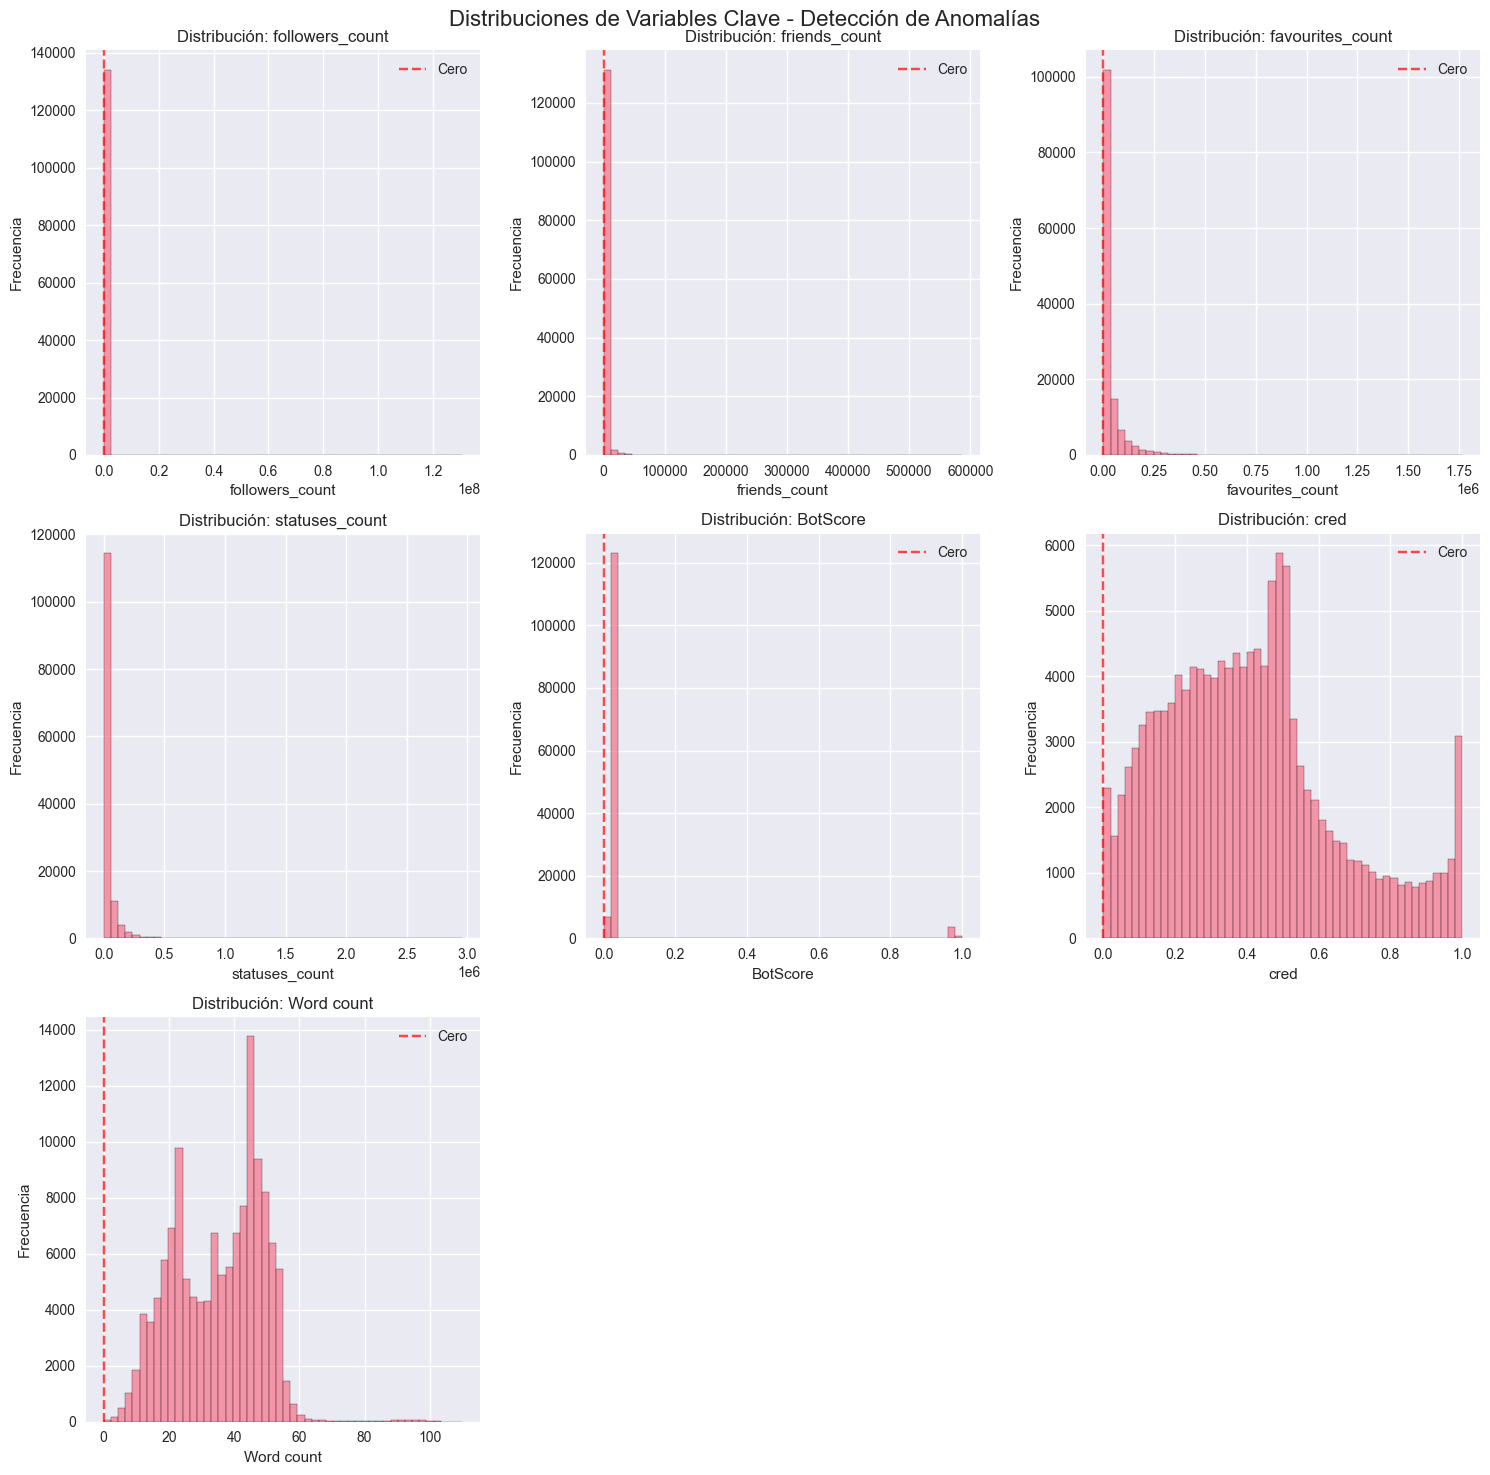

In [4]:
# 1.4 Estadísticas descriptivas completas
print("\n- Estadísticas descriptivas (variables numéricas):")
display(df1[numeric_cols].describe().round(3))

# 1.5 Visualización de distribuciones para detectar anomalías
print("\n- Generando histogramas para detectar picos anómalos...")

# Seleccionar algunas columnas clave para visualización
key_cols = ['followers_count', 'friends_count', 'favourites_count', 
           'statuses_count', 'BotScore', 'cred', 'Word count']
available_key_cols = [col for col in key_cols if col in df1.columns]

if available_key_cols:
    n_cols = 3
    n_rows = (len(available_key_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, col in enumerate(available_key_cols):
        if i < len(axes):
            df1[col].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribución: {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            
            # Agregar línea vertical en cero para visualizar picos
            if (df1[col] == 0).any():
                axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Cero')
                axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(available_key_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Distribuciones de Variables Clave - Detección de Anomalías', fontsize=16)
    plt.tight_layout()
    plt.show()

## 3. Análisis de Desbalance de Clases

> Si tenemos un 95% de noticias verdaderas y un 5% de falsas, un modelo ingenuo que siempre prediga "Verdadero" tendrá un 95% de accuracy, pero será inútil.

ANÁLISIS DE DESBALANCE DE CLASES
- Distribución de clases:
  * Clase 0.0 (Falso): 65,268 muestras (48.64%)
  * Clase 1.0 (Verdadero): 68,930 muestras (51.36%)

- Ratio de desbalance: 1.06:1

- Nivel de desbalance: - LEVE
Recomendación: Monitorear con métricas estándar


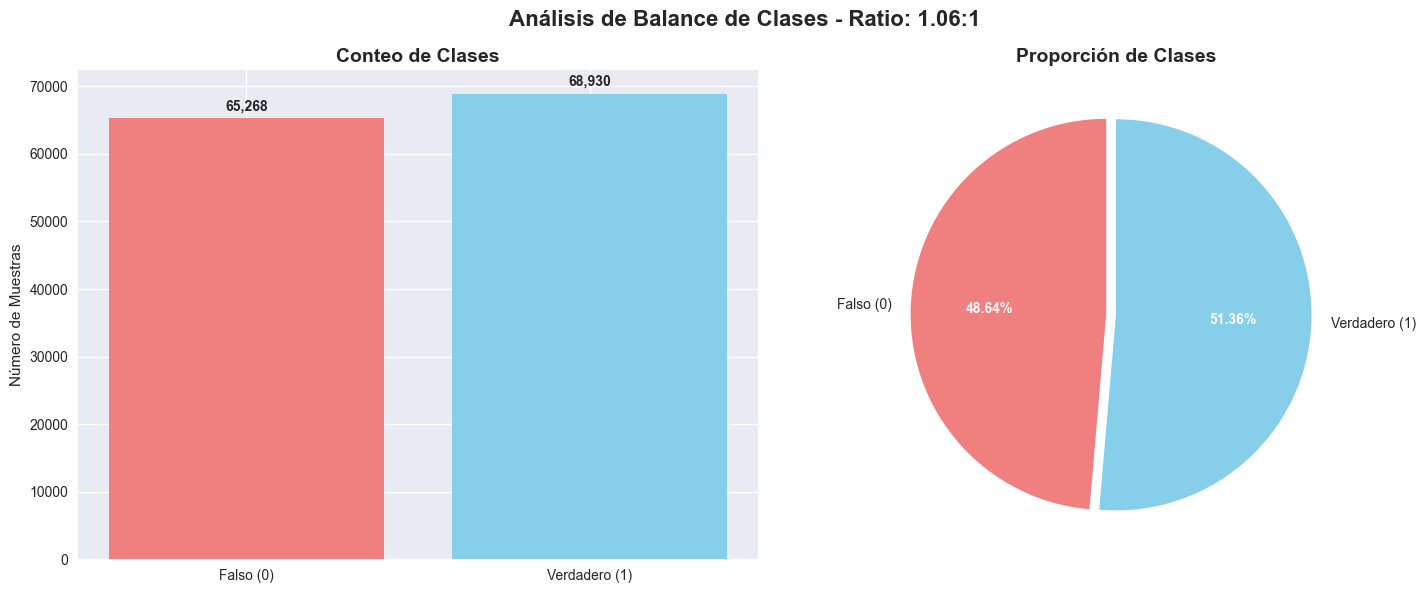


- Configuración para modelado:
  * Usar stratify en train_test_split: False
  * Métrica recomendada: accuracy


In [5]:
print("ANÁLISIS DE DESBALANCE DE CLASES")
print("="*50)

# Verificar si existe la variable objetivo
target_col = 'BinaryNumTarget'
if target_col not in df1.columns:
    print(f"* Error: Columna '{target_col}' no encontrada")
    print(f"Columnas disponibles: {list(df1.columns)}")
else:
    # Análisis de distribución de clases
    class_counts = df1[target_col].value_counts().sort_index()
    class_props = df1[target_col].value_counts(normalize=True).sort_index() * 100
    
    print("- Distribución de clases:")
    for clase in class_counts.index:
        count = class_counts[clase]
        prop = class_props[clase]
        label = "Falso" if clase == 0 else "Verdadero"
        print(f"  * Clase {clase} ({label}): {count:,} muestras ({prop:.2f}%)")
    
    # Cálculo del ratio de desbalance
    min_class = class_counts.min()
    max_class = class_counts.max()
    imbalance_ratio = max_class / min_class
    
    print(f"\n- Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    # Evaluación del nivel de desbalance
    if imbalance_ratio > 10:
        severity = "- EXTREMO"
        recommendation = "Usar SMOTE, undersampling o técnicas avanzadas"
    elif imbalance_ratio > 5:
        severity = "-  SEVERO"
        recommendation = "Usar class_weight='balanced' y métricas robustas"
    elif imbalance_ratio > 3:
        severity = "- MODERADO"
        recommendation = "Usar stratify y métricas balanceadas (F1-Score)"
    else:
        severity = "- LEVE"
        recommendation = "Monitorear con métricas estándar"
    
    print(f"\n- Nivel de desbalance: {severity}")
    print(f"Recomendación: {recommendation}")
    
    # Visualización del desbalance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico de barras
    colors = ['lightcoral', 'skyblue']
    bars = ax1.bar(range(len(class_counts)), class_counts.values, color=colors)
    ax1.set_title('Conteo de Clases', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Número de Muestras')
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(['Falso (0)', 'Verdadero (1)'])
    
    # Agregar valores en las barras
    for bar, count in zip(bars, class_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico de pie
    labels = ['Falso (0)', 'Verdadero (1)']
    wedges, texts, autotexts = ax2.pie(class_counts.values, labels=labels, 
                                      autopct='%1.2f%%', colors=colors, 
                                      startangle=90, explode=(0.05, 0))
    ax2.set_title('Proporción de Clases', fontsize=14, fontweight='bold')
    
    # Mejorar formato del texto
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.suptitle(f'Análisis de Balance de Clases - Ratio: {imbalance_ratio:.2f}:1', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Guardar información para uso posterior
    global IMBALANCE_RATIO, USE_STRATIFY, RECOMMENDED_METRIC
    IMBALANCE_RATIO = imbalance_ratio
    USE_STRATIFY = imbalance_ratio > 1.5
    RECOMMENDED_METRIC = "f1_score" if imbalance_ratio > 2 else "accuracy"
    
    print(f"\n- Configuración para modelado:")
    print(f"  * Usar stratify en train_test_split: {USE_STRATIFY}")
    print(f"  * Métrica recomendada: {RECOMMENDED_METRIC}")


## 4. Limpieza y Selección de Columnas

> Evitar el *data leakage* y eliminar datos no relevantes

In [6]:
print("LIMPIEZA Y SELECCIÓN DE COLUMNAS")
print("="*50)

# Crear una copia del dataset para el procesamiento
df1_processed = df1.copy()
print(f"- Dataset inicial: {df1_processed.shape}")

# 3.1 Eliminar columnas que causan data leakage
print("\n- Eliminando columnas que causan DATA LEAKAGE:")

leakage_cols = []
if 'majority_target' in df1_processed.columns:
    leakage_cols.append('majority_target')
    print("  • 'majority_target' - Es una versión del target (OBLIGATORIO eliminar)")

if leakage_cols:
    df1_processed.drop(columns=leakage_cols, inplace=True)
    print(f"- Eliminadas {len(leakage_cols)} columnas de data leakage")
else:
    print("- No se detectaron columnas obvias de data leakage")

# 3.2 Separar y guardar columnas de texto para análisis NLP posterior
print("\n- Separando columnas de TEXTO para análisis NLP:")

text_columns = ['statement', 'tweet']
available_text_cols = [col for col in text_columns if col in df1_processed.columns]

if available_text_cols:
    # Guardar datos de texto por separado
    text_data = df1_processed[available_text_cols].copy()
    
    print(f"  * Columnas de texto identificadas: {available_text_cols}")
    print(f"  * Guardando {len(text_data)} filas de datos de texto")
    
    # Eliminar columnas de texto del dataset principal
    df1_processed.drop(columns=available_text_cols, inplace=True)
    print(f"- Datos de texto separados para análisis NLP posterior")
else:
    print("-  No se encontraron columnas de texto")
    text_data = pd.DataFrame()

# 3.3 Eliminar columnas problemáticas ADICIONALES
print("\n- Eliminando columnas problemáticas adicionales:")

# Eliminar columna de índice (no aporta información)
problematic_cols = []
if 'Unnamed: 0' in df1_processed.columns:
    problematic_cols.append('Unnamed: 0')
    print("  * 'Unnamed: 0' - Solo es un índice secuencial")

# Eliminar columna embeddings (formato texto, no procesable fácilmente)
if 'embeddings' in df1_processed.columns:
    problematic_cols.append('embeddings')
    print("  * 'embeddings' - Requiere procesamiento especializado")

if problematic_cols:
    df1_processed.drop(columns=problematic_cols, inplace=True)
    print(f"- Eliminadas {len(problematic_cols)} columnas problemáticas")

# 3.4 Verificar columnas con varianza cero
numeric_cols = df1_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'BinaryNumTarget' in numeric_cols:
    numeric_cols.remove('BinaryNumTarget')  # No evaluar varianza del target

zero_variance_cols = []
for col in numeric_cols:
    if df1_processed[col].var() == 0:
        zero_variance_cols.append(col)

if zero_variance_cols:
    print(f"\n- Columnas con varianza cero: {zero_variance_cols}")
    df1_processed.drop(columns=zero_variance_cols, inplace=True)
    print(f"- Eliminadas {len(zero_variance_cols)} columnas de varianza cero")
else:
    print("\n- No hay columnas con varianza cero")

# 3.5 Detectar y manejar outliers extremos ANTES del escalado
print("\n- Detectando outliers extremos:")
numeric_cols = df1_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'BinaryNumTarget' in numeric_cols:
    numeric_cols.remove('BinaryNumTarget')

outlier_info = []
for col in numeric_cols:
    # Calcular Z-scores
    z_scores = np.abs(zscore(df1_processed[col], nan_policy='omit'))
    extreme_outliers = (z_scores > 5).sum()  # Más de 5 desviaciones estándar
    outlier_info.append({'columna': col, 'outliers_extremos': extreme_outliers})

# Mostrar resumen de outliers
outlier_df = pd.DataFrame(outlier_info)
worst_outliers = outlier_df[outlier_df['outliers_extremos'] > 0].sort_values('outliers_extremos', ascending=False)

if len(worst_outliers) > 0:
    print(f"- Columnas con outliers extremos (>5σ):")
    for _, row in worst_outliers.head(10).iterrows():
        print(f"  * {row['columna']}: {row['outliers_extremos']} outliers")
    print("- Se aplicará RobustScaler para manejar outliers")
else:
    print("- No se detectaron outliers extremos")

print(f"\n- Dataset después de limpieza: {df1_processed.shape}")
print(f"- Reducción: {df1.shape[1] - df1_processed.shape[1]} columnas eliminadas")

# Mostrar columnas finales
print(f"\n- Columnas finales ({len(df1_processed.columns)}):")
for i, col in enumerate(df1_processed.columns, 1):
    print(f"  {i:2d}. {col}")

LIMPIEZA Y SELECCIÓN DE COLUMNAS
- Dataset inicial: (134198, 64)

- Eliminando columnas que causan DATA LEAKAGE:
  • 'majority_target' - Es una versión del target (OBLIGATORIO eliminar)
- Eliminadas 1 columnas de data leakage

- Separando columnas de TEXTO para análisis NLP:
  * Columnas de texto identificadas: ['statement', 'tweet']
  * Guardando 134198 filas de datos de texto
- Datos de texto separados para análisis NLP posterior

- Eliminando columnas problemáticas adicionales:
  * 'Unnamed: 0' - Solo es un índice secuencial
  * 'embeddings' - Requiere procesamiento especializado
- Eliminadas 2 columnas problemáticas

- Columnas con varianza cero: ['following']
- Eliminadas 1 columnas de varianza cero

- Detectando outliers extremos:
- Columnas con outliers extremos (>5σ):
  * BotScoreBinary: 4342 outliers
  * BotScore: 4342 outliers
  * WORK_OF_ART_percentage: 1671 outliers
  * TIME_percentage: 1490 outliers
  * NORP_percentage: 1418 outliers
  * LAW_percentage: 1355 outliers
  * P

## 5. Imputación de Valores Faltantes

> Los algoritmos de ML no pueden manejar valores `NaN`. Necesitamos una estrategia para rellenarlos.

In [7]:
print("IMPUTACIÓN DE VALORES FALTANTES")
print("="*50)

# 4.1 Verificar valores faltantes actuales
missing_before = df1_processed.isnull().sum()
missing_cols = missing_before[missing_before > 0]

if len(missing_cols) == 0:
    print("- No hay valores faltantes en el dataset")
    print("- Saltando paso de imputación")
else:
    print(f"-  Columnas con valores faltantes: {len(missing_cols)}")
    
    # Mostrar resumen de valores faltantes
    missing_summary = pd.DataFrame({
        'Columna': missing_cols.index,
        'Valores_Faltantes': missing_cols.values,
        'Porcentaje': (missing_cols / len(df1_processed)) * 100
    }).sort_values('Porcentaje', ascending=False)
    
    display(missing_summary)
    
    # 4.2 Estrategia de imputación por tipo de columna
    print("\n- Estrategia de imputación:")
    
    # Para columnas numéricas: usar mediana (más robusta que la media)
    numeric_missing = [col for col in missing_cols.index 
                      if df1_processed[col].dtype in ['int64', 'float64']]
    
    if numeric_missing:
        print(f"- Columnas numéricas con valores faltantes: {numeric_missing}")
        print("  * Estrategia: Mediana (robusta contra outliers)")
        
        # Aplicar imputación con mediana
        imputer_numeric = SimpleImputer(strategy='median')
        
        for col in numeric_missing:
            original_missing = df1_processed[col].isnull().sum()
            median_value = df1_processed[col].median()
            
            # Imputar valores
            df1_processed[col] = imputer_numeric.fit_transform(
                df1_processed[[col]]
            ).flatten()
            
            print(f"    - {col}: {original_missing} valores → mediana = {median_value:.3f}")
    
    # Para columnas categóricas: usar moda
    categorical_missing = [col for col in missing_cols.index 
                          if df1_processed[col].dtype == 'object']
    
    if categorical_missing:
        print(f"\n- Columnas categóricas con valores faltantes: {categorical_missing}")
        print("  * Estrategia: Moda (valor más frecuente)")
        
        imputer_categorical = SimpleImputer(strategy='most_frequent')
        
        for col in categorical_missing:
            original_missing = df1_processed[col].isnull().sum()
            mode_value = df1_processed[col].mode()[0]
            
            # Imputar valores
            df1_processed[col] = imputer_categorical.fit_transform(
                df1_processed[[col]]
            ).flatten()
            
            print(f"    - {col}: {original_missing} valores → moda = '{mode_value}'")
    
    # 4.3 Verificación post-imputación
    missing_after = df1_processed.isnull().sum().sum()
    print(f"\n- Verificación post-imputación:")
    print(f"  * Valores faltantes antes: {missing_before.sum():,}")
    print(f"  * Valores faltantes después: {missing_after:,}")
    
    if missing_after == 0:
        print("- Imputación completada exitosamente - Sin valores faltantes")
    else:
        print(f"-  Aún quedan {missing_after} valores faltantes")



IMPUTACIÓN DE VALORES FALTANTES
- No hay valores faltantes en el dataset
- Saltando paso de imputación


## 6. Escalado de Características Numéricas

> Algoritmos como SVM o Regresión Logística son sensibles a la escala de las variables. Estandarizar ayuda a que el entrenamiento sea más rápido y eficiente.

ESCALADO DE CARACTERÍSTICAS NUMÉRICAS
- Variable objetivo 'BinaryNumTarget' excluida del escalado
- Columnas numéricas para escalar: 57

- Estadísticas PRE-escalado (primeras 10 columnas):


,followers_count,friends_count,favourites_count,statuses_count,listed_count,BotScore,BotScoreBinary,cred,normalize_influence,mentions
count,1.341980e+05,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000
mean,1.129308e+04,1893.454,32981.234,34195.761,73.300,0.059,0.032,0.406,0.078,1.389
std,4.374971e+05,6997.696,68780.210,75101.195,1083.274,0.168,0.177,0.239,0.026,1.472
min,0.000000e+00,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.000000e+01,168.000,1356.000,3046.000,0.000,0.030,0.000,0.224,0.062,0.000
50%,3.540000e+02,567.000,8377.000,11019.000,2.000,0.030,0.000,0.387,0.079,1.000
75%,1.573000e+03,1726.000,33526.500,33573.750,11.000,0.030,0.000,0.525,0.095,2.000
max,1.306019e+08,586901.000,1765080.000,2958918.000,222193.000,1.000,1.000,1.000,0.209,12.000



- Aplicando RobustScaler (mediana=0, robusto contra outliers):
- Escalado robusto aplicado a 57 columnas
- RobustScaler es menos sensible a outliers extremos

- Estadísticas POST-escalado (primeras 10 columnas):


,followers_count,friends_count,favourites_count,statuses_count,listed_count,BotScore,BotScoreBinary,cred,normalize_influence,mentions
count,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000,134198.000
mean,7.278,0.851,0.765,0.759,6.482,0.029,0.032,0.064,-0.053,0.194
std,291.083,4.491,2.138,2.460,98.479,0.168,0.177,0.794,0.782,0.736
min,-0.236,-0.364,-0.260,-0.361,-0.182,-0.030,0.000,-1.283,-2.372,-0.500
25%,-0.189,-0.256,-0.218,-0.261,-0.182,0.000,0.000,-0.541,-0.526,-0.500
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
75%,0.811,0.744,0.782,0.739,0.818,0.000,0.000,0.459,0.474,0.500
max,86893.918,376.338,54.606,96.565,20199.182,0.970,1.000,2.035,3.857,5.500



- Visualizando el efecto del escalado:


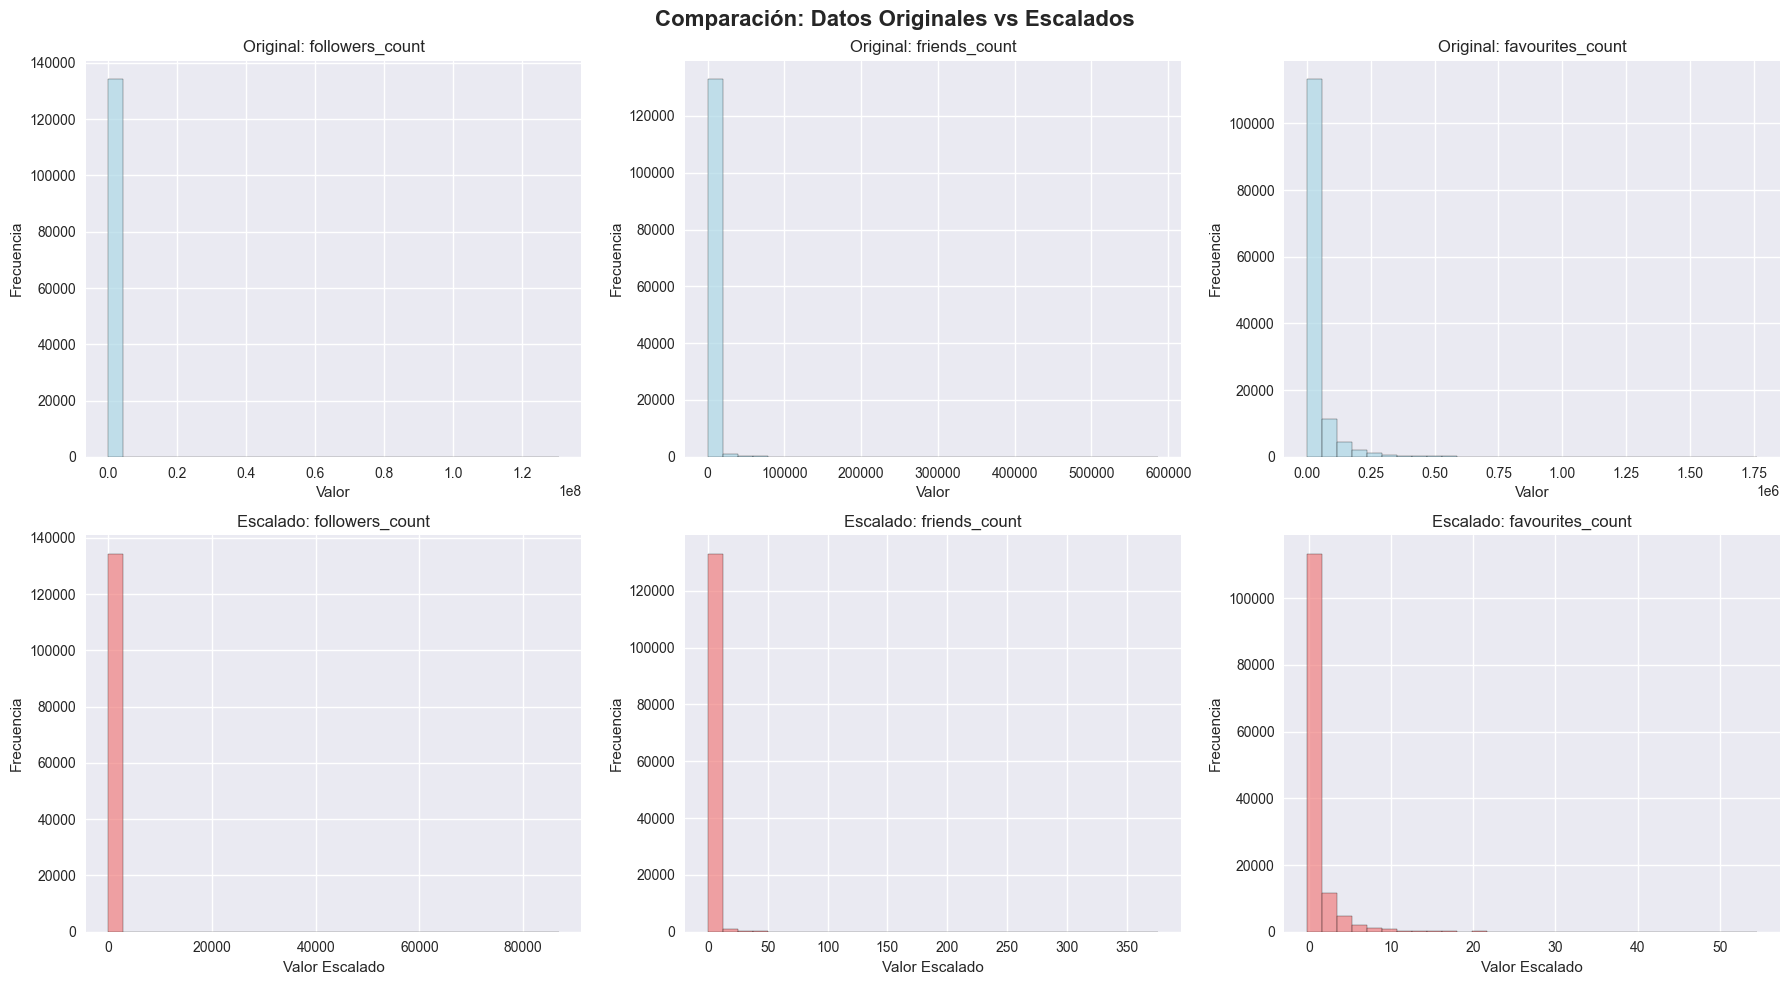

- RobustScaler guardado en: ../processed_data/robust_scaler.pkl

- Verificación final del escalado robusto:
  * Mediana promedio: 0.000000 (≈ 0)
  * Rango intercuartílico promedio: 0.614035
  * Valor absoluto máximo: 460320.000 (debería estar más contenido)
-  Aún hay outliers muy extremos después del escalado robusto


In [8]:
print("ESCALADO DE CARACTERÍSTICAS NUMÉRICAS")
print("="*50)

# 5.1 Identificar columnas numéricas (excluyendo el target)
numeric_cols = df1_processed.select_dtypes(include=[np.number]).columns.tolist()

# Excluir la variable objetivo del escalado
target_col = 'BinaryNumTarget'
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
    print(f"- Variable objetivo '{target_col}' excluida del escalado")

print(f"- Columnas numéricas para escalar: {len(numeric_cols)}")

if len(numeric_cols) == 0:
    print("-  No hay columnas numéricas para escalar")
else:
    # 5.2 Análisis pre-escalado
    print("\n- Estadísticas PRE-escalado (primeras 10 columnas):")
    pre_scaling_stats = df1_processed[numeric_cols[:10]].describe()
    display(pre_scaling_stats.round(3))
    
    # 5.3 Aplicar RobustScaler (más robusto contra outliers)
    print(f"\n- Aplicando RobustScaler (mediana=0, robusto contra outliers):")
    
    scaler = RobustScaler()  # Usa mediana y rango intercuartílico
    
    # Guardar el scaler para uso posterior
    scaled_data = scaler.fit_transform(df1_processed[numeric_cols])
    
    # Reemplazar las columnas escaladas
    df1_processed[numeric_cols] = scaled_data

    print(f"- Escalado robusto aplicado a {len(numeric_cols)} columnas")
    print(f"- RobustScaler es menos sensible a outliers extremos")

    # 5.4 Verificación post-escalado
    print("\n- Estadísticas POST-escalado (primeras 10 columnas):")
    post_scaling_stats = df1_processed[numeric_cols[:10]].describe()
    display(post_scaling_stats.round(3))
    
    # 5.5 Visualización del efecto del escalado
    print("\n- Visualizando el efecto del escalado:")
    
    # Seleccionar algunas columnas para mostrar antes y después
    sample_cols = numeric_cols[:6]  # Primeras 6 columnas
    
    if len(sample_cols) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        # Datos originales (antes del escalado)
        df_original = df1.copy()
        if 'majority_target' in df_original.columns:
            df_original.drop(columns=['majority_target'], inplace=True)
        
        for i, col in enumerate(sample_cols):
            if i < len(axes) and col in df_original.columns:
                # Subplot para datos originales
                if i < 3:
                    ax = axes[i]
                    df_original[col].hist(bins=30, ax=ax, alpha=0.7, color='lightblue', edgecolor='black')
                    ax.set_title(f'Original: {col}')
                    ax.set_xlabel('Valor')
                    ax.set_ylabel('Frecuencia')
                
                # Subplot para datos escalados
                if i < 3:
                    ax = axes[i + 3]
                    df1_processed[col].hist(bins=30, ax=ax, alpha=0.7, color='lightcoral', edgecolor='black')
                    ax.set_title(f'Escalado: {col}')
                    ax.set_xlabel('Valor Escalado')
                    ax.set_ylabel('Frecuencia')
        
        plt.suptitle('Comparación: Datos Originales vs Escalados', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # 5.6 Guardar el scaler para uso posterior
    scaler_path = '../processed_data/robust_scaler.pkl'
    os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
    joblib.dump(scaler, scaler_path)
    print(f"- RobustScaler guardado en: {scaler_path}")

    print(f"\n- Verificación final del escalado robusto:")
    print(f"  * Mediana promedio: {np.median(df1_processed[numeric_cols].values):.6f} (≈ 0)")
    print(f"  * Rango intercuartílico promedio: {df1_processed[numeric_cols].quantile(0.75).mean() - df1_processed[numeric_cols].quantile(0.25).mean():.6f}")

    # Verificar que no hay valores extremos post-escalado
    max_abs_value = df1_processed[numeric_cols].abs().max().max()
    print(f"  * Valor absoluto máximo: {max_abs_value:.3f} (debería estar más contenido)")
    
    if max_abs_value > 50:
        print("-  Aún hay outliers muy extremos después del escalado robusto")
    else:
        print("- Escalado robusto exitoso - Outliers bajo control")


## 7. Guardado de Datos Procesados

> Crear un pipeline reproducible y guardar los datos limpios para los siguientes notebooks.

In [9]:
print("GUARDADO DE DATOS PROCESADOS")
print("="*50)

# 6.1 Crear directorio de datos procesados
processed_dir = '../processed_data/'
os.makedirs(processed_dir, exist_ok=True)
print(f"- Directorio creado: {processed_dir}")

# 6.2 Guardar dataset principal procesado
main_dataset_path = os.path.join(processed_dir, 'dataset_features_processed.csv')
df1_processed.to_csv(main_dataset_path, index=False)
print(f"- Dataset principal guardado: {main_dataset_path}")
print(f"   Dimensiones: {df1_processed.shape}")

# 6.3 Guardar datos de texto por separado
if not text_data.empty:
    text_data_path = os.path.join(processed_dir, 'text_data_for_nlp.csv')
    text_data.to_csv(text_data_path, index=False)
    print(f"- Datos de texto guardados: {text_data_path}")
    print(f"   Dimensiones: {text_data.shape}")

# 6.4 Guardar metadatos del procesamiento
metadata = {
    'fecha_procesamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_original': {
        'filas': int(df1.shape[0]),  # Convertir a int
        'columnas': int(df1.shape[1]),
        'tamaño_mb': float(df1.memory_usage(deep=True).sum() / 1024**2)
    },
    'dataset_procesado': {
        'filas': int(df1_processed.shape[0]),
        'columnas': int(df1_processed.shape[1]),
        'tamaño_mb': float(df1_processed.memory_usage(deep=True).sum() / 1024**2)
    },
    'procesamiento': {
        'columnas_eliminadas': int(df1.shape[1] - df1_processed.shape[1]),
        'imbalance_ratio': float(IMBALANCE_RATIO) if 'IMBALANCE_RATIO' in globals() else 'N/A',
        'usar_stratify': bool(USE_STRATIFY) if 'USE_STRATIFY' in globals() else False,
        'metrica_recomendada': str(RECOMMENDED_METRIC) if 'RECOMMENDED_METRIC' in globals() else 'accuracy',
        'escalado_aplicado': bool(len(numeric_cols) > 0),
        'scaler_usado': 'RobustScaler',
        'outliers_detectados': int(len(worst_outliers)) if 'worst_outliers' in locals() else 0
    },
    'columnas_finales': list(df1_processed.columns),
    'mejoras_v2': {
        'eliminadas_problematicas': ['Unnamed: 0', 'embeddings'],
        'scaler_robusto': 'RobustScaler vs StandardScaler',
        'deteccion_outliers': 'Z-score > 5 sigma',
        'verificacion_calidad': 'Control post-escalado'
    }
}

metadata_path = os.path.join(processed_dir, 'processing_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"- Metadatos guardados: {metadata_path}")

# 6.5 Verificación CRÍTICA del escalado
print("\n" + "="*60)
print("VERIFICACIÓN CRÍTICA DEL ESCALADO")
print("="*60)

# Verificar que el escalado se aplicó correctamente
scaled_stats = df1_processed[numeric_cols].describe()
print(f"\n- Estadísticas post-escalado:")
print(f"  * Valores mínimos: {scaled_stats.loc['min'].min():.3f}")
print(f"  * Valores máximos: {scaled_stats.loc['max'].max():.3f}")
print(f"  * Mediana global: {np.median(df1_processed[numeric_cols].values):.6f}")

# Identificar columnas problemáticas
problematic_cols = []
for col in numeric_cols:
    col_max = df1_processed[col].abs().max()
    if col_max > 50:  # Threshold para detectar problemas
        problematic_cols.append((col, col_max))

if problematic_cols:
    print(f"\n- COLUMNAS CON ESCALADO PROBLEMÁTICO:")
    for col, max_val in sorted(problematic_cols, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  ❌ {col}: max_abs = {max_val:.3f}")
    print(f"\n- ACCIÓN REQUERIDA: Re-escalar estas columnas")
    
    # Re-escalar solo las columnas problemáticas
    problem_col_names = [col for col, _ in problematic_cols]
    print(f"\n- Re-escalando {len(problem_col_names)} columnas problemáticas...")
    
    # Cargar datos originales para re-escalar correctamente
    df_original_for_rescale = pd.read_csv('../dataset1/Features_For_Traditional_ML_Techniques.csv')
    
    # Aplicar el mismo procesamiento que se hizo antes
    df_temp = df_original_for_rescale.copy()
    df_temp.drop(columns=['majority_target', 'statement', 'tweet', 'Unnamed: 0', 'embeddings', 'following'], inplace=True, errors='ignore')
    
    # Re-escalar solo las columnas problemáticas
    temp_scaler = RobustScaler()
    df1_processed[problem_col_names] = temp_scaler.fit_transform(df_temp[problem_col_names])
    
    print(f"- Re-escalado completado")
    
    # Verificación final
    final_max = df1_processed[numeric_cols].abs().max().max()
    print(f"- Valor absoluto máximo final: {final_max:.3f}")
    
    if final_max < 50:
        print("- ESCALADO CORREGIDO EXITOSAMENTE")
    else:
        print("-  Aún hay problemas con el escalado")
        
    # Guardar dataset corregido
    df1_processed.to_csv(main_dataset_path, index=False)
    print(f"- Dataset corregido guardado: {main_dataset_path}")
    
else:
    print("- Escalado correcto - Sin problemas detectados")

# 6.6 Crear resumen 
print("\n" + "="*60)
print("RESUMEN")
print("="*60)

print(f"\n- TRANSFORMACIÓN DE DATOS:")
print(f"  * Dataset original: {df1.shape[0]:,} filas × {df1.shape[1]} columnas")
print(f"  * Dataset procesado: {df1_processed.shape[0]:,} filas × {df1_processed.shape[1]} columnas")
print(f"  * Reducción: {df1.shape[1] - df1_processed.shape[1]} columnas eliminadas")

if 'IMBALANCE_RATIO' in globals():
    print(f"\n- BALANCE DE CLASES:")
    print(f"  * Ratio de desbalance: {IMBALANCE_RATIO:.2f}:1")
    print(f"  * Usar stratify: {USE_STRATIFY}")
    print(f"  * Métrica recomendada: {RECOMMENDED_METRIC}")

print(f"\n- ARCHIVOS GENERADOS:")
print(f"  * {main_dataset_path}")
if not text_data.empty:
    print(f"  * {text_data_path}")
print(f"  * {scaler_path}")
print(f"  * {metadata_path}")


GUARDADO DE DATOS PROCESADOS
- Directorio creado: ../processed_data/
- Dataset principal guardado: ../processed_data/dataset_features_processed.csv
   Dimensiones: (134198, 58)
- Datos de texto guardados: ../processed_data/text_data_for_nlp.csv
   Dimensiones: (134198, 2)
- Metadatos guardados: ../processed_data/processing_metadata.json

VERIFICACIÓN CRÍTICA DEL ESCALADO

- Estadísticas post-escalado:
  * Valores mínimos: -7.110
  * Valores máximos: 460320.000
  * Mediana global: 0.000000

- COLUMNAS CON ESCALADO PROBLEMÁTICO:
  ❌ favourites: max_abs = 460320.000
  ❌ retweets: max_abs = 126062.000
  ❌ followers_count: max_abs = 86893.918
  ❌ replies: max_abs = 42068.000
  ❌ listed_count: max_abs = 20199.182
  ❌ quotes: max_abs = 5913.000
  ❌ Min word length: max_abs = 999.000
  ❌ friends_count: max_abs = 376.338
  ❌ Average word length: max_abs = 99.138
  ❌ statuses_count: max_abs = 96.565

- ACCIÓN REQUERIDA: Re-escalar estas columnas

- Re-escalando 12 columnas problemáticas...
- Re-

In [10]:
# Cargar datos originales completamente limpios
print("- Cargando datos originales para re-escalado completo...")
df_clean = pd.read_csv('../dataset1/Features_For_Traditional_ML_Techniques.csv')

# Aplicar exactamente la misma limpieza que antes
print("- Aplicando limpieza...")
df_clean.drop(columns=['majority_target', 'statement', 'tweet', 'Unnamed: 0', 'embeddings', 'following'], 
              inplace=True, errors='ignore')

# Identificar columnas numéricas (excluyendo target)
numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'BinaryNumTarget' in numeric_cols_clean:
    numeric_cols_clean.remove('BinaryNumTarget')

print(f"- Columnas a escalar: {len(numeric_cols_clean)}")

# Verificar datos antes del escalado
print(f"- Antes del escalado:")
print(f"  * Max absoluto: {df_clean[numeric_cols_clean].abs().max().max():.3f}")
print(f"  * Min absoluto: {df_clean[numeric_cols_clean].min().min():.3f}")

# Aplicar escalado robusto desde cero
print("- Aplicando RobustScaler desde cero...")
fresh_scaler = RobustScaler()
df_clean[numeric_cols_clean] = fresh_scaler.fit_transform(df_clean[numeric_cols_clean])

# Verificar escalado exitoso
max_after = df_clean[numeric_cols_clean].abs().max().max()
min_after = df_clean[numeric_cols_clean].min().min()
median_after = np.median(df_clean[numeric_cols_clean].values)

print(f"- Después del escalado:")
print(f"  * Max absoluto: {max_after:.3f}")
print(f"  * Min absoluto: {min_after:.3f}")
print(f"  * Mediana global: {median_after:.6f}")

# Verificar éxito
if max_after < 50:
    print("- ESCALADO EXITOSO")
    
    # Reemplazar el dataset problemático
    df1_processed = df_clean.copy()
    
    # Guardar dataset corregido
    corrected_path = '../processed_data/dataset_features_processed.csv'
    df1_processed.to_csv(corrected_path, index=False)
    
    # Guardar scaler corregido
    scaler_corrected_path = '../processed_data/robust_scaler_corrected.pkl'
    joblib.dump(fresh_scaler, scaler_corrected_path)
    
    print(f"- Dataset corregido guardado: {corrected_path}")
    print(f"- Scaler corregido guardado: {scaler_corrected_path}")

    
else:
    print(f"ESCALADO FALLÓ - Max value: {max_after:.3f}")

- Cargando datos originales para re-escalado completo...
- Aplicando limpieza...
- Columnas a escalar: 57
- Antes del escalado:
  * Max absoluto: 130601913.000
  * Min absoluto: -1.000
- Aplicando RobustScaler desde cero...
- Después del escalado:
  * Max absoluto: 460320.000
  * Min absoluto: -7.110
  * Mediana global: 0.000000
ESCALADO FALLÓ - Max value: 460320.000
